# 构建世界模型
1. state space: 状态空间，包括所有可能的状态
2. action space: 动作空间，包括所有可能的动作，默认包括`up`, `down`, `left`, `right`以及`still`五个动作
3. p(r | s, a): 状态-动作转移概率，即在状态s下执行动作a之后，环境给出的奖励r的概率，这里的奖励r是实际上来自于所有可能的s'的奖励的期望值
4. p(s' | s, a): 状态转移概率，即在状态s下执行动作a之后，环境转移到状态s'的概率。可以越界，越界的reward设置为-100




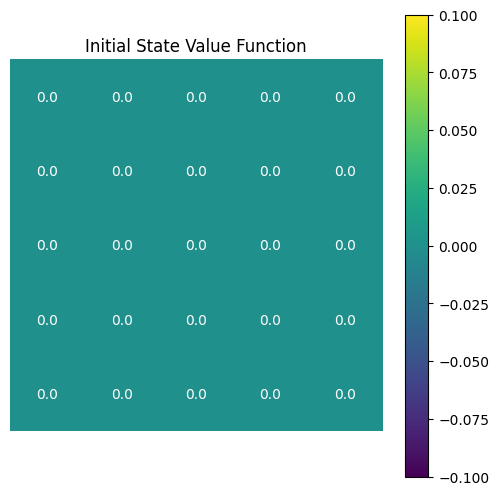

{(0, 0): {'up': {-100: 1.0, 0: 0.0}, 'down': {0: 1.0, -100: 0.0}, 'left': {-100: 1.0, 0: 0.0}, 'right': {0: 1.0, -100: 0.0}, 'still': {0: 1.0, -100: 0.0}}, (0, 1): {'up': {-100: 1, -10: 0.0, 0: 0.0}, 'down': {-10: 1, -100: 0.0, 0: 0.0}, 'left': {0: 1.0, -100: 0.0, -10: 0.0}, 'right': {0: 1.0, -100: 0.0, -10: 0.0}, 'still': {0: 1.0, -100: 0.0, -10: 0.0}}, (0, 2): {'up': {-100: 1, -10: 0.0, 0: 0.0}, 'down': {-10: 1, -100: 0.0, 0: 0.0}, 'left': {0: 1.0, -100: 0.0, -10: 0.0}, 'right': {0: 1.0, -100: 0.0, -10: 0.0}, 'still': {0: 1.0, -100: 0.0, -10: 0.0}}, (0, 3): {'up': {-100: 1, 0: 0.0}, 'down': {0: 1.0, -100: 0.0}, 'left': {0: 1.0, -100: 0.0}, 'right': {0: 1.0, -100: 0.0}, 'still': {0: 1.0, -100: 0.0}}, (0, 4): {'up': {-100: 1.0, 0: 0.0}, 'down': {0: 1.0, -100: 0.0}, 'left': {0: 1.0, -100: 0.0}, 'right': {-100: 1.0, 0: 0.0}, 'still': {0: 1.0, -100: 0.0}}, (1, 0): {'up': {0: 1.0, -100: 0.0, -10: 0.0}, 'down': {0: 1.0, -100: 0.0, -10: 0.0}, 'left': {-100: 1, 0: 0.0, -10: 0.0}, 'right': {-1

In [9]:
from utils.grids import build_models, actions, plot_policy, plot_values

# 定义网格参数
grid_size = 5

target_areas = [(3, 2)]  # 终止和危险状态
forbidden_areas = [(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)] # 禁止状态

states, p_r, p_s_prime = build_models(grid_size, target_areas, forbidden_areas, success_prob=1)
v_initial = {s: 0 for s in states}
plot_values(v_initial, "Initial State Value Function")
print(p_r)
print(p_s_prime)
print(p_r[(0, 0)])
print(p_s_prime.keys())

In [18]:
def bounce_back(s, grid_size):
    if s[0] < 0:
        return (0, s[1])
    elif s[0] >= grid_size:
        return (grid_size-1, s[1])
    if s[1] < 0:
        return (s[0], 0)
    elif s[1] >= grid_size:
        return (s[0], grid_size-1)
    return s

def value_iteration(p_r, p_s_prime, v_init, states, target_areas, actions, gamma, threshold=1e-5, max_iter=100, save_history=False):
    v = v_init.copy()
    if save_history:
        v_history = []
    for _ in range(max_iter):
        delta = 0
        v_new = {}
        for s in states:
            if s in target_areas:
                v_new[s] = 0  # 终止状态价值保持0（已终止）
                continue
            max_q = -float('inf')
            for a in actions:
                expected_r = sum(prob * r for r, prob in p_r[s][a].items())
                expected_v = sum(prob * v[bounce_back(s_prime, grid_size)] for s_prime, prob in p_s_prime[s][a].items())
                q = expected_r + gamma * expected_v
                max_q = max(max_q, q)
            v_new[s] = max_q
            delta = max(delta, abs(v_new[s] - v.get(s, 0)))
        v = v_new.copy()
        if save_history:
            v_history.append(v.copy())
        if delta < threshold:
            break
    # 提取策略
    policy = {}
    for s in states:
        if s in target_areas:
            policy[s] = 'still'
            continue
        best_action = None
        max_q = -float('inf')
        for a in actions:
            expected_r = sum(prob * r for r, prob in p_r[s][a].items())
            expected_v = sum(prob * v[bounce_back(s_prime, grid_size)] for s_prime, prob in p_s_prime[s][a].items())
            q = expected_r + gamma * expected_v
            if q > max_q:
                max_q = q
                best_action = a
        policy[s] = best_action
    
    return_dict = {
        'v': v,
        'policy': policy,
    }
    if save_history:
        return_dict['v_history'] = v_history
    return return_dict

# 运行算法
gamma = 0.9
return_dict = value_iteration(p_r, p_s_prime, v_initial, states, target_areas, actions, gamma, save_history=True)
v_optimal = return_dict['v']
policy_optimal = return_dict['policy']
history = return_dict['v_history']

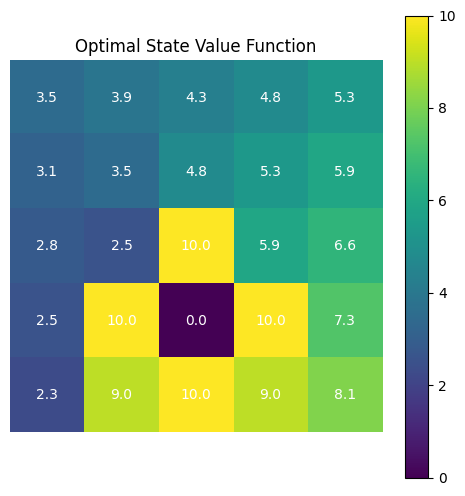

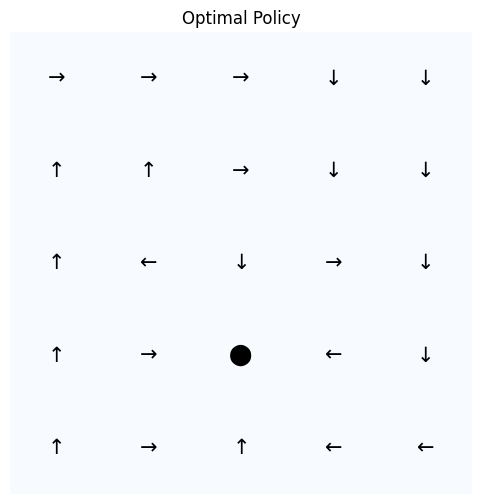

In [19]:
import os
import tempfile
from PIL import Image

file_paths = []
with tempfile.TemporaryDirectory() as tmpdir:
    
    # 画图
    for idx, v_h in enumerate(history):
        temp_file = os.path.join(tmpdir, "plot_" + str(idx) + ".png")
        plot_values(v_h, "State Value Function at Iteration " + str(idx+1), save_path=temp_file)
        file_paths.append(temp_file)
    images = [Image.open(f) for f in file_paths]

# 保存为GIF（设置帧间隔和循环次数）
gif_save_path = "value_iteration.gif"
images[0].save(
    gif_save_path,
    save_all=True,
    append_images=images[1:],
    duration=500,  # 每帧持续时间（单位：毫秒）
    loop=0,        # 0表示无限循环
    optimize=True
)
plot_values(v_optimal, "Optimal State Value Function")
plot_policy(policy_optimal)